#EECS 442/504 PS7: Object Detection

__Please provide the following information__
(e.g. Andrew Owens, ahowens):

Bernardo Bianco Prado, beprado

__Important__: after you download the .ipynb file, please name it as __"PS\<this_ps_number\>_\<your_uniqname\>.ipynb"__ before you submit it to canvas. Example: adam_01101100.ipynb.



# FCOS: A Simple One-Stage and Anchor-Free Object Detector

In this exercise you will implement a single-stage object detector based on [FCOS: Fully-Convolutional One-Stage Object Detection](https://arxiv.org/abs/1904.01355) and train it to detect a set of object classes.
Our detector design is highly similar to FCOS itself, except we train a smaller model with slightly different hyperparameters to manage with limited resources on Colab.

This problem set will use a small version of the popular image detection dataset Pascal VOC. 

We will also evaluate the detection accuracy using the mean Average Precision ([mAP](https://github.com/Cartucho/mAP)).

**Acknowledgement**: This problem set has been adapted from EECS 598/498 Deep Learning for Computer Vision taught by Prof. Justin Johnson.

# 7.1 (a) Getting started 

In [ ]:
#install some python modules we need
!pip -q install wget
!pip -q install gdown

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data._utils.collate import default_collate
from torch import optim
from torchvision import transforms
import torchvision
from torchvision import models
from torchvision.models import feature_extraction
from torchvision.ops import sigmoid_focal_loss,nms

import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib
import torch
from PIL import Image

from typing import Optional, Dict, List, Optional, Tuple
import wget
import gdown
import json
import random
import tarfile
import time
import shutil

In [ ]:
# check GPU
if torch.cuda.is_available():
    print("Using the GPU!")
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cuda")
    print("WARNING: Could not find GPU! Using CPU only. If you want to enable GPU, please to go Edit > Notebook Settings > Hardware Accelerator and select GPU.")

Using the GPU!


In [ ]:
# for plotting
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # set default size of plots
plt.rcParams["font.size"] = 16
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

In [ ]:
# some global variables, do not overwrite later
NUM_CLASSES = 20
BATCH_SIZE = 16
IMAGE_SHAPE = (224, 224)
NUM_WORKERS = 2
TensorDict = Dict[str, torch.Tensor]

## Import helper functions 

In this problem, we have written the dataloader for you. This dataloader and some other helper functions have been consolidated in a python file which will be downloaded and imported in the follwing cells. 



In [ ]:
# download the helpers file 
gdown.download(url = "https://drive.google.com/uc?export=download&id=1dXe4i306p99plNMkUBjbsvfcSIYTy6hM", output="/content/ps7_helpers.py")

Downloading...
From: https://drive.google.com/uc?export=download&id=1dXe4i306p99plNMkUBjbsvfcSIYTy6hM
To: /content/ps7_helpers.py
100%|██████████| 25.2k/25.2k [00:00<00:00, 27.4MB/s]


'/content/ps7_helpers.py'

In [ ]:
from ps7_helpers import VOC2007Detection, train_detector, infinite_loader, reset_seed, detection_visualizer, rel_error

## Load dataset and visualize

To train our detector, we need to convert individual images (JPEG) and annotations (XML files) into batches of tensors. We perform this by wrapping our datasets with a PyTorch [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) object.
We have implemented it in `ps7_helpers.py` - you are not required to understand its implementation, however you should understand the format of its output.

In [ ]:
train_dataset = VOC2007Detection(
    "/content", "train", image_size=IMAGE_SHAPE[0],
    download=True  # True (for the first time and every subsequent reconnect of runtime)
)
val_dataset = VOC2007Detection("/content", "val", image_size=IMAGE_SHAPE[0])

print("Dataset sizes: train ({}), val ({})".format(len(train_dataset),len(val_dataset)))

Downloading...
From: https://drive.google.com/uc?export=download&id=1CgcCgt6A_IYZzH9-Muu3U9zvEXyICFbn
To: /content/voc07_train.json
100%|██████████| 575k/575k [00:00<00:00, 60.8MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&id=1thjODvV9zrfw4zb8yybf9sfzQ_vtzy3W
To: /content/voc07_val.json
100%|██████████| 574k/574k [00:00<00:00, 69.4MB/s]


Dataset sizes: train (2501), val (2510)


In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, pin_memory=True, num_workers=NUM_WORKERS
)

# Use batch_size = 1 during inference - during inference we do not center crop
# the image to detect all objects, hence they may be of different size. It is
# easier and less redundant to use batch_size=1 rather than zero-padding images.
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=1, pin_memory=True, num_workers=NUM_WORKERS
)

The `DataLoader` objects return batches of data.

The first output from the `DataLoader` is a Tensor `image` of shape `(B, 3, IMAGE_SHAPE[0], IMAGE_SHAPE[1])`. This is a batch of `B` images, similar to what we have seen in classification datasets.

The second output from the `DataLoader` is a Tensor `gt_boxes` of shape `(B, N, 5)` giving information about all objects in all images of the batch. `gt_boxes[i, j] = (x1, y1, x2, y2, C)` gives information about the `j`th object in `image[i]`. The position of the top-left corner of the box is `(x1, y1)` and the position of the bottom-right corner of the box is `(x2, x2)`. These coordinates are real-valued in `[0, 224]`. `C` is an integer giving the category label for this bounding box. This `(x1, y1, x2, y2)` format for bounding boxes is commonly referred as XYXY format.

Each image can have different numbers of objects. If `image[i]` has $N_i$ objects, then $N = \max_i(N_i)$ is the maximum number of objects per image among all objects in the batch; this value can vary from batch to batch. For the images that have fewer than $N$ annotated objects, only the first $N_i$ rows of `gt_boxes[i]` contain annotations; the remaining rows are padded with -1.

In [ ]:
train_loader_iter = iter(train_loader)
image_paths, images, gt_boxes = train_loader_iter.next()

print("image paths           : {}".format(image_paths))
print("image batch has shape : {}".format(images.shape))
print("gt_boxes has shape    : {}".format(gt_boxes.shape))

print("Five boxes per image  :")
print(gt_boxes[:, 0, :])

image paths           : ['/content/VOCdevkit/VOC2007/JPEGImages/000012.jpg', '/content/VOCdevkit/VOC2007/JPEGImages/000017.jpg', '/content/VOCdevkit/VOC2007/JPEGImages/000023.jpg', '/content/VOCdevkit/VOC2007/JPEGImages/000026.jpg', '/content/VOCdevkit/VOC2007/JPEGImages/000032.jpg', '/content/VOCdevkit/VOC2007/JPEGImages/000033.jpg', '/content/VOCdevkit/VOC2007/JPEGImages/000034.jpg', '/content/VOCdevkit/VOC2007/JPEGImages/000035.jpg', '/content/VOCdevkit/VOC2007/JPEGImages/000036.jpg', '/content/VOCdevkit/VOC2007/JPEGImages/000042.jpg', '/content/VOCdevkit/VOC2007/JPEGImages/000044.jpg', '/content/VOCdevkit/VOC2007/JPEGImages/000047.jpg', '/content/VOCdevkit/VOC2007/JPEGImages/000048.jpg', '/content/VOCdevkit/VOC2007/JPEGImages/000061.jpg', '/content/VOCdevkit/VOC2007/JPEGImages/000064.jpg', '/content/VOCdevkit/VOC2007/JPEGImages/000066.jpg']
image batch has shape : torch.Size([16, 3, 224, 224])
gt_boxes has shape    : torch.Size([16, 40, 5])
Five boxes per image  :
tensor([[ 48.9369

## Visualize PASCAL VOC 2007

Before starting to build your model, it is highly recommended that you visualize your training data and observe some examples. This can help uncover any bugs in dataloading and sometimes even give you strong intuitions to include a modeling component!

We also use a function to visualize our detections, implemented in `ps7_helpers`. You are not required to understand it but we encourage you to read it! Here we sample some images from the PASCAL VOC 2007 training set, and visualize the ground-truth object boxes and category labels:

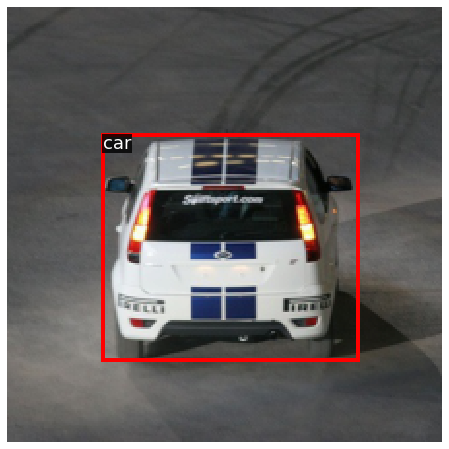

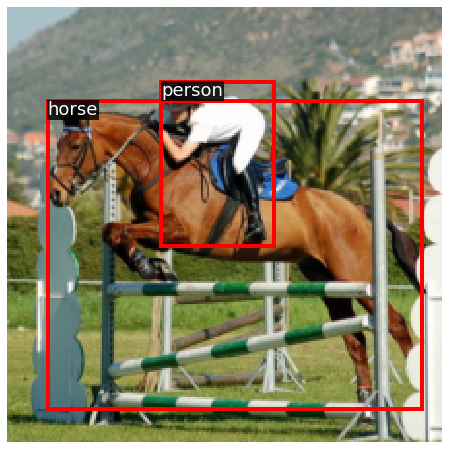

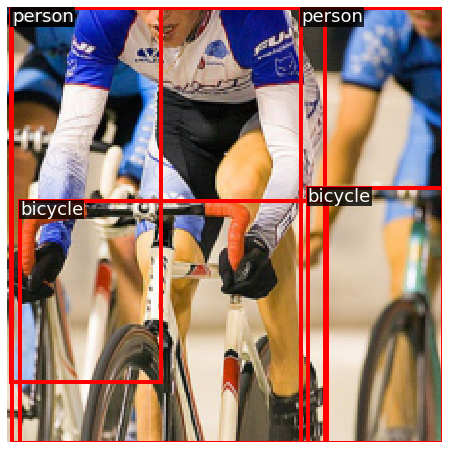

In [ ]:
# Define an "inverse" transform for the image that un-normalizes by ImageNet 
# color and mean. Without this, the images will NOT be visually understandable. 
# You can check how it will look otherwise by just commenting line which applies
# the inverser norm.

inverse_norm = transforms.Compose(
    [
        transforms.Normalize(mean=[0., 0., 0.], std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
        transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1., 1., 1.]),
    ]
)

for idx, (_, image, gt_boxes) in enumerate(train_dataset):
    # Stop after visualizing three images.
    if idx > 2:
        break

    # Un-normalize image to bring in [0, 1] RGB range.
    image = inverse_norm(image)

    # Remove padded boxes from visualization.
    is_valid = gt_boxes[:, 4] >= 0
    detection_visualizer(image, val_dataset.idx_to_class, gt_boxes[is_valid])

## 7.1 (b) Implementing Backbone and Feature Pyramid Network 

First, we start building the backbone and FPN of our detector (blue and green parts above). It is the core component that takes in an image and outputs its features of different scales. It can be any type of convolutional network that progressively downsamples the image.

Here, we use a small [RegNetX-400MF](https://pytorch.org/vision/stable/models.html#torchvision.models.regnet_x_400mf) as the backbone so we can train in reasonable time on Colab. We have already implemented the minimal logic to initialize this backbone from pre-trained ImageNet weights and extract intermediate features `(c3, c4, c5)` as shown in the figure above.
These features `(c3, c4, c5)` have height and width that is ${1/8}^{th}$, ${1/16}^{th}$, and ${1/32}^{th}$ of the input image respectively.
These values `(8, 16, 32)` are called the "stride" of these features.
In other words, it means that moving one location on the FPN level is equivalent to moving `stride` pixels in the input image.

You need to implement extra modules to attach the FPN to this backbone. For more details, see Figure 3 in [FPN paper](https://arxiv.org/abs/1612.03144).
FPN will convert these `(c3, c4, c5)` multi-scale features to `(p3, p4, p5)`. These notations "p3", "p4", "p5" are called _FPN levels_.

Before you write any code, let's initialize the backbone in the next cell. You should see the shape of `(c3, c4, c5)` features for an input image:

Follow the instructions below to implement additional FPN layers for transforming `(c3, c4, c5)` to `(p3, p4, p5)`.
For training a small enough model on Google Colab, we leave out `(p6, p7)` as shown in the Figure.
Output features from these FPN levels are expected to have same height and width as backbone features, but now they should have the same number of channels.

In [ ]:
class DetectorBackboneWithFPN(nn.Module):
    """
    Detection backbone network: A tiny RegNet model coupled with a Feature
    Pyramid Network (FPN). This model takes in batches of input images with
    shape `(B, 3, H, W)` and gives features from three different FPN levels
    with shapes and total strides upto that level:

        - level p3: (out_channels, H /  8, W /  8)      stride =  8
        - level p4: (out_channels, H / 16, W / 16)      stride = 16
        - level p5: (out_channels, H / 32, W / 32)      stride = 32

    NOTE: We could use any convolutional network architecture that progressively
    downsamples the input image and couple it with FPN. We use a small enough
    backbone that can work with Colab GPU and get decent enough performance.
    """

    def __init__(self, out_channels: int):
        super().__init__()
        self.out_channels = out_channels

        # Initialize with ImageNet pre-trained weights.
        _cnn = models.regnet_x_400mf(weights="IMAGENET1K_V2")

        # Torchvision models only return features from the last level. Detector
        # backbones (with FPN) require intermediate features of different scales.
        # So we wrap the ConvNet with torchvision's feature extractor. Here we
        # will get output features with names (c3, c4, c5) with same stride as
        # (p3, p4, p5) described above.
        self.backbone = feature_extraction.create_feature_extractor(
            _cnn,
            return_nodes={
                "trunk_output.block2": "c3",
                "trunk_output.block3": "c4",
                "trunk_output.block4": "c5",
            },
        )

        # Pass a dummy batch of input images to infer shapes of (c3, c4, c5).
        # Features are a dictionary with keys as defined above. Values are
        # batches of tensors in NCHW format, that give intermediate features
        # from the backbone network.
        dummy_out = self.backbone(torch.randn(2, 3, 224, 224))
        dummy_out_shapes = [(key, value.shape) for key, value in dummy_out.items()]

        print("For dummy input images with shape: (2, 3, 224, 224)")
        for level_name, feature_shape in dummy_out_shapes:
            print(f"Shape of {level_name} features: {feature_shape}")

        ######################################################################
        # TODO: Initialize additional Conv layers for FPN.                   #
        #                                                                    #
        # Create THREE "lateral" 1x1 conv layers to transform (c3, c4, c5)   #
        # such that they all end up with the same `out_channels`.            #
        # Then create THREE "output" 3x3 conv layers to transform the merged #
        # FPN features to output (p3, p4, p5) features.                      #
        # All conv layers must have stride=1 and padding such that features  #
        # do not get downsampled due to 3x3 convs.                           #
        #                                                                    #
        # HINT: You have to use `dummy_out_shapes` defined above to decide   #
        # the input/output channels of these layers.                         #
        ######################################################################
        # This behaves like a Python dict, but makes PyTorch understand that
        # there are trainable weights inside it.
        # Add THREE lateral 1x1 conv and THREE output 3x3 conv layers.
        self.fpn_params = nn.ModuleDict()

        # lateral convolutions
        for level_name, feature_shape in dummy_out_shapes:
          self.fpn_params.add_module(
              "lat_" + level_name, nn.Conv2d(feature_shape[1], out_channels, kernel_size=1)
              )
          
        
        #self.fpn_params.add_module("lat_c4", nn.Conv2d(dummy_out_shapes["c4"][1],
        #                                               out_channels, 
        #                                               kernel_size=1))
        #self.fpn_params.add_module("lat_c5", nn.Conv2d(dummy_out_shapes["c5"][1],
        #                                               out_channels, 
        #                                               kernel_size=1))
        
        # conv layers
        self.fpn_params.add_module("conv_p3", nn.Conv2d(out_channels, out_channels,
                                                        kernel_size=3, padding=1))
        self.fpn_params.add_module("conv_p4", nn.Conv2d(out_channels, out_channels,
                                                        kernel_size=3, padding=1))
        self.fpn_params.add_module("conv_p5", nn.Conv2d(out_channels, out_channels,
                                                        kernel_size=3, padding=1))

        ######################################################################
        #                            END OF YOUR CODE                        #
        ######################################################################

    @property
    def fpn_strides(self):
        """
        Total stride up to the FPN level. For a fixed ConvNet, these values
        are invariant to input image size. You may access these values freely
        to implement your logic in FCOS / Faster R-CNN.
        """
        return {"p3": 8, "p4": 16, "p5": 32}

    def forward(self, images: torch.Tensor):

        # Multi-scale features, dictionary with keys: {"c3", "c4", "c5"}.
        backbone_feats = self.backbone(images)

        fpn_feats = {"p3": None, "p4": None, "p5": None}
        ######################################################################
        # TODO: Fill output FPN features (p3, p4, p5) using RegNet features  #
        # (c3, c4, c5) and FPN conv layers created above.                    #
        # HINT: Use `F.interpolate` to upsample FPN features.                #
        ######################################################################

        
        p5 = self.fpn_params["lat_c5"](backbone_feats["c5"])
        fpn_feats["p5"] = self.fpn_params["conv_p5"](p5)

        p4 = self.fpn_params["lat_c4"](backbone_feats["c4"])
        p4 = p4 + F.interpolate(p5, scale_factor=2)
        fpn_feats["p4"] = self.fpn_params["conv_p4"](p4)

        p3 = self.fpn_params["lat_c3"](backbone_feats["c3"])
        p3 = p3 + F.interpolate(p4, scale_factor=2)
        fpn_feats["p3"] = self.fpn_params["conv_p3"](p3)

        ######################################################################
        #                            END OF YOUR CODE                        #
        ######################################################################

        return fpn_feats

In [ ]:
backbone = DetectorBackboneWithFPN(out_channels=64)

Downloading: "https://download.pytorch.org/models/regnet_x_400mf-62229a5f.pth" to /root/.cache/torch/hub/checkpoints/regnet_x_400mf-62229a5f.pth


  0%|          | 0.00/21.3M [00:00<?, ?B/s]

For dummy input images with shape: (2, 3, 224, 224)
Shape of c3 features: torch.Size([2, 64, 28, 28])
Shape of c4 features: torch.Size([2, 160, 14, 14])
Shape of c5 features: torch.Size([2, 400, 7, 7])


## 7.1 (c) Implementing FCOS prediction network (head)

By this point, you have implemented the backbone and FPN.  

Now we implement the "head" prediction layers (**orange** blocks in the Figure above). This head has shared weights across all FPN levels, and its purpose is to predict an object class, bounding box, and centerness at every location.

Look closely at the right block in the Figure which shows the inner components of head. It comprises 4-convolution layers that produce `(H, W, 256)` features (different H, W for different FPN levels) and then use one convolutional layer each to make final predictions. 

You will now add these modules in `FCOSPredictionNetwork` - follow instructions in its documentation.
Below we show how to initialize and use this module.

In the expected output the classification logits have `NUM_CLASSES` channels, box regression deltas have 4 output channels, and centerness has 1 output channels.
The height and width of all outputs is flattened to one dimension, resulting in `(B, H * W, C)` format - this format is more convenient for computing loss, as you will see later.


In [ ]:
class FCOSPredictionNetwork(nn.Module):
    """
    FCOS prediction network that accepts FPN feature maps from different levels
    and makes three predictions at every location: bounding boxes, class ID and
    centerness. This module contains a "stem" of convolution layers, along with
    one final layer per prediction. For a visual depiction, see Figure 2 (right
    side) in FCOS paper: https://arxiv.org/abs/1904.01355

    We will use feature maps from FPN levels (P3, P4, P5) and exclude (P6, P7).
    """

    def __init__(
        self, num_classes: int, in_channels: int, stem_channels: List[int]
    ):
        """
        Args:
            num_classes: Number of object classes for classification.
            in_channels: Number of channels in input feature maps. This value
                is same as the output channels of FPN, since the head directly
                operates on them.
            stem_channels: List of integers giving the number of output channels
                in each convolution layer of stem layers (orange blocks in the Figure above).
        """
        super().__init__()

        ######################################################################
        # TODO: Create a stem of alternating 3x3 convolution layers and RELU
        # activation modules. Note there are two separate stems for class and
        # box stem. The prediction layers for box regression and centerness
        # operate on the output of `stem_box`.
        # See FCOS figure again; both stems are identical.
        #
        # Use `in_channels` and `stem_channels` for creating these layers, the
        # docstring above tells you what they mean. Initialize weights of each
        # conv layer from a normal distribution with mean = 0 and std dev = 0.01
        # and all biases with zero. Use conv stride = 1 and zero padding such
        # that size of input features remains same: remember we need predictions
        # at every location in feature map, we shouldn't "lose" any locations.
        ######################################################################

        # create stem convolutions
        stem_cls = []
        stem_box = []
        for i in range(0,len(stem_channels)):
          # add convolutions
          if i == 0:
            stem_cls.append(nn.Conv2d(in_channels, stem_channels[0], kernel_size=3, padding=1))
            stem_box.append(nn.Conv2d(in_channels, stem_channels[0], kernel_size=3, padding=1))
          else:
            stem_cls.append(nn.Conv2d(stem_channels[i-1], stem_channels[i], kernel_size=3, padding=1))
            stem_box.append(nn.Conv2d(stem_channels[i-1], stem_channels[i], kernel_size=3, padding=1))
          # initialize weights and bias
          nn.init.normal_(stem_cls[-1].weight, mean=0, std=0.01)
          nn.init.constant_(stem_cls[-1].bias, 0)
          nn.init.normal_(stem_box[-1].weight, mean=0, std=0.01)
          nn.init.constant_(stem_box[-1].bias, 0)
          # add relu
          stem_cls.append(nn.ReLU())
          stem_box.append(nn.ReLU())
        
        ######################################################################
        
        # Wrap the layers defined by student into a `nn.Sequential` module:
        self.stem_cls = nn.Sequential(*stem_cls)
        self.stem_box = nn.Sequential(*stem_box)

        ######################################################################
        # TODO: Create THREE 3x3 conv layers for individually predicting three
        # things at every location of feature map:
        #     1. object class logits (`num_classes` outputs)
        #     2. box regression deltas (4 outputs: LTRB deltas from locations)
        #     3. centerness logits (1 output)
        #
        # Class probability and actual centerness are obtained by applying
        # sigmoid activation to these logits. However, DO NOT initialize those
        # modules here. This module should always output logits; PyTorch loss
        # functions have numerically stable implementations with logits. During
        # inference, logits are converted to probabilities by applying sigmoid,
        # BUT OUTSIDE this module.
        #
        ######################################################################

        # Replace these lines with your code, keep variable names unchanged.
        self.pred_cls = nn.Conv2d(stem_channels[-1], num_classes, kernel_size=3, stride=1, padding=1)  # Class prediction conv
        self.pred_box = nn.Conv2d(stem_channels[-1], 4, kernel_size=3, stride=1, padding=1)  # Box regression conv
        self.pred_ctr = nn.Conv2d(stem_channels[-1], 1, kernel_size=3, stride=1, padding=1)  # Centerness conv

        ######################################################################
        #                           END OF YOUR CODE                         #
        ######################################################################

        # OVERRIDE: Use a negative bias in `pred_cls` to improve training
        # stability. Without this, the training will most likely diverge.
        # STUDENTS: You do not need to get into details of why this is needed.
        torch.nn.init.constant_(self.pred_cls.bias, -math.log(99))

    def forward(self, feats_per_fpn_level: TensorDict) -> List[TensorDict]:
        """
        Accept FPN feature maps and predict the desired outputs at every location
        (as described above). Format them such that channels are placed at the
        last dimension, and (H, W) are flattened (having channels at last is
        convenient for computing loss as well as perforning inference).

        Args:
            feats_per_fpn_level: Features from FPN, keys {"p3", "p4", "p5"}. Each
                tensor will have shape `(batch_size, fpn_channels, H, W)`. For an
                input (224, 224) image, H = W are (28, 14, 7) for (p3, p4, p5).

        Returns:
            List of dictionaries, each having keys {"p3", "p4", "p5"}:
            1. Classification logits: `(batch_size, H * W, num_classes)`.
            2. Box regression deltas: `(batch_size, H * W, 4)`
            3. Centerness logits:     `(batch_size, H * W, 1)`
        """

        ######################################################################
        # TODO: Iterate over every FPN feature map and obtain predictions using
        # the layers defined above. Remember that prediction layers of box
        # regression and centerness will operate on output of `stem_box`,
        # and classification layer operates separately on `stem_cls`.
        #
        # CAUTION: The original FCOS model uses shared stem for centerness and
        # classification. Recent follow-up papers commonly place centerness and
        # box regression predictors with a shared stem, which we follow here.
        #
        # DO NOT apply sigmoid to classification and centerness logits.
        ######################################################################
        # Fill these with keys: {"p3", "p4", "p5"}, same as input dictionary.
        class_logits = {}
        boxreg_deltas = {}
        centerness_logits = {}

        # apply heads to p3
        h3_class = self.stem_cls(feats_per_fpn_level["p3"])
        h3_class = self.pred_cls(h3_class)
        class_logits["p3"] = h3_class.permute((0,2,3,1)).view(h3_class.shape[0], -1, h3_class.shape[1])
        h3_box = self.stem_box(feats_per_fpn_level["p3"])
        h3_boxreg = self.pred_box(h3_box)
        boxreg_deltas["p3"] = h3_boxreg.permute((0,2,3,1)).view(h3_boxreg.shape[0], -1, 4)
        h3_center = self.pred_ctr(h3_box)
        centerness_logits["p3"] = h3_center.permute((0,2,3,1)).view(h3_center.shape[0], -1, 1)
        # apply heads to p4
        h4_class = self.stem_cls(feats_per_fpn_level["p4"])
        h4_class = self.pred_cls(h4_class)
        class_logits["p4"] = h4_class.permute((0,2,3,1)).view(h4_class.shape[0], -1, h4_class.shape[1])
        h4_box = self.stem_box(feats_per_fpn_level["p4"])
        h4_boxreg = self.pred_box(h4_box)
        boxreg_deltas["p4"] = h4_boxreg.permute((0,2,3,1)).view(h4_boxreg.shape[0], -1, 4)
        h4_center = self.pred_ctr(h4_box)
        centerness_logits["p4"] = h4_center.permute((0,2,3,1)).view(h4_center.shape[0], -1, 1)
        # apply heads to p5        
        h5_class = self.stem_cls(feats_per_fpn_level["p5"])
        h5_class = self.pred_cls(h5_class)
        class_logits["p5"] = h5_class.permute((0,2,3,1)).view(h5_class.shape[0], -1, h5_class.shape[1])
        h5_box = self.stem_box(feats_per_fpn_level["p5"])
        h5_boxreg = self.pred_box(h5_box)
        boxreg_deltas["p5"] = h5_boxreg.permute((0,2,3,1)).view(h5_boxreg.shape[0], -1, 4)
        h5_center = self.pred_ctr(h5_box)
        centerness_logits["p5"] = h5_center.permute((0,2,3,1)).view(h5_center.shape[0], -1, 1)
    
        ######################################################################
        #                           END OF YOUR CODE                         #
        ######################################################################

        return [class_logits, boxreg_deltas, centerness_logits]

Running the cell below should give output similar to this:

```
FCOS prediction network parameters:
FCOSPredictionNetwork(
  (stem_cls): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (stem_box): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (pred_cls): Conv2d(64, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pred_box): Conv2d(64, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pred_ctr): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
```



In [ ]:
# Tiny head with `in_channels` as FPN output channels in prior cell,
# and two conv layers in stem.
pred_net = FCOSPredictionNetwork(
    num_classes=NUM_CLASSES, in_channels=64, stem_channels=[128, 64]
)

print("FCOS prediction network parameters:")
print(pred_net)

FCOS prediction network parameters:
FCOSPredictionNetwork(
  (stem_cls): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (stem_box): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (pred_cls): Conv2d(64, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pred_box): Conv2d(64, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pred_ctr): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


## Train the FCOS

You have now finished implementing FCOS and it is ready to train!
Did you notice that all the trainable layers you implemented so far — in FPN and in prediction layers — are convolutional layers?
Due to this design, FCOS gets _fully-convolutional_ in its name!
It performs object detection with _only_ convolution layers, and no special anchors, proposals etc.
The next few steps focus on preparing the training pipeline for FCOS.

Recall that image classification models are trained with `(image, label)` pairs,
where `label` is an integer (more concretely a one-hot vector) that is associated with the _entire_ image.
You cannot train an object detector in this fashion because of two reasons:

1. Each image has a variable number of bounding boxes (and their class labels).
2. Any class label is not associated with an entire image, but rather only a small region enclosed by the bounding box.

Since the object detector classifies every location in feature map along with a bounding box and centerness, we need to supervise every prediction with _one and only one_ GT target. In next few cells, you will work through this assignment procedure between predictions and GT boxes.

### 7.1 (d) Assigning a GT target to every model prediction
FCOS heads make three predictions at every location: object class, bounding box, and centerness. We need to assign a GT target for each of them during training. All three predictions correspond to a single location on an FPN level `(p3, p4, p5)`, so instead we can view this problem as assigning GT boxes (and their class labels) to every FPN feature map location.

GT boxes are available (from the dataloader) as 5D vectors `(x1, y1, x2, y2, C)` where `(x1, y1)` is the top-left co-ordinate and `(x2, y2)` is the bottom-right co-ordinate of the bounding box, and C is its object class label. These co-ordinates are absolute and real-valued in image dimensions. To begin with the assignment, we will represent every location on an FPN level with (xc, yc) absolute and real-valued co-ordinates of a point on the image, that are centers of the receptive fields of those features.

For example, given features from FPN level having shape `(batch_size, channels, H / stride, W / stride)` and the location `feature[:, :, i, j]` will map to the image pixel `(stride * (i + 0.5), stride * (j + 0.5))` indicates the shift from top-left corner to the center of "stride box".

Implement the `get_fpn_location_coords` to get (xc, yc) location co-ordinates of all FPN features. Follow its documentation and see its usage example in the following cell:

In [ ]:
def get_fpn_location_coords(
    shape_per_fpn_level: Dict[str, Tuple],
    strides_per_fpn_level: Dict[str, int],
    dtype: torch.dtype = torch.float32,
    device: str = "cpu",
) -> Dict[str, torch.Tensor]:
    """
    Map every location in FPN feature map to a point on the image. This point
    represents the center of the receptive field of this location. We need to
    do this for having a uniform co-ordinate representation of all the locations
    across FPN levels, and GT boxes.

    Args:
        shape_per_fpn_level: Shape of the FPN feature level, dictionary of keys
            {"p3", "p4", "p5"} and feature shapes `(B, C, H, W)` as values.
        strides_per_fpn_level: Dictionary of same keys as above, each with an
            integer value giving the stride of corresponding FPN level.

    Returns:
        Dict[str, torch.Tensor]
            Dictionary with same keys as `shape_per_fpn_level` and values as
            tensors of shape `(H * W, 2)` giving `(xc, yc)` co-ordinates of the
            centers of receptive fields of the FPN locations, on input image.
    """

    # Set these to `(N, 2)` Tensors giving absolute location co-ordinates.
    location_coords = {
        level_name: None for level_name, _ in shape_per_fpn_level.items()
    }

    for level_name, feat_shape in shape_per_fpn_level.items():
        level_stride = strides_per_fpn_level[level_name]

        ######################################################################
        # TODO: Implement logic to get location co-ordinates below.          #
        ######################################################################
        # Replace "pass" statement with your code

        h, w  = feat_shape[2:]
        #positions = [[level_stride * (j + 0.5), level_stride * (i + 0.5)]
        #             for i in range(w) for j in range(h)]
        #location_coords[level_name] = torch.tensor(positions).view(-1,2)
        
        x = level_stride * (torch.arange(w).view([1,-1,1]) + 0.5)
        x = x.repeat(h,1,1)
        y = level_stride * (torch.arange(h).view([-1,1,1]) + 0.5)
        y = y.repeat(1,w,1)
        positions = torch.cat((x,y), axis=2)
        location_coords[level_name] = positions.view(-1,2).to(device=device)
        
        ######################################################################
        #                             END OF YOUR CODE                       #
        ######################################################################
    return location_coords



Running the cell below should give output similar to this:

```
Extra FPN modules added:
ModuleDict(
  (conv5): Conv2d(400, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv4): Conv2d(160, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv3_out): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_out): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_out): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
For dummy input images with shape: torch.Size([2, 3, 224, 224])
Shape of p3 features: torch.Size([2, 64, 28, 28])
Shape of p4 features: torch.Size([2, 64, 14, 14])
Shape of p5 features: torch.Size([2, 64, 7, 7])
```



In [ ]:
print("Extra FPN modules added:")
print(backbone.fpn_params)

# Pass a batch of dummy images (random tensors) in NCHW format and observe the output.
dummy_images = torch.randn(2, 3, 224, 224)

# Collect dummy output.
dummy_fpn_feats = backbone(dummy_images)

print(f"For dummy input images with shape: {dummy_images.shape}")
for level_name, feat in dummy_fpn_feats.items():
    print(f"Shape of {level_name} features: {feat.shape}")

Extra FPN modules added:
ModuleDict(
  (lat_c3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (lat_c4): Conv2d(160, 64, kernel_size=(1, 1), stride=(1, 1))
  (lat_c5): Conv2d(400, 64, kernel_size=(1, 1), stride=(1, 1))
  (conv_p3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_p4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_p5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)
For dummy input images with shape: torch.Size([2, 3, 224, 224])
Shape of p3 features: torch.Size([2, 64, 28, 28])
Shape of p4 features: torch.Size([2, 64, 14, 14])
Shape of p5 features: torch.Size([2, 64, 7, 7])


First five locations per FPN level (absolute image co-ordinates):
p3: [[4.0, 4.0], [12.0, 4.0], [20.0, 4.0], [28.0, 4.0], [36.0, 4.0]]
rel error:  0.0
p4: [[8.0, 8.0], [24.0, 8.0], [40.0, 8.0], [56.0, 8.0], [72.0, 8.0]]
rel error:  0.0
p5: [[16.0, 16.0], [48.0, 16.0], [80.0, 16.0], [112.0, 16.0], [144.0, 16.0]]
rel error:  0.0
********************************************************************************
All locations of the image FPN level = p3
stride = 8


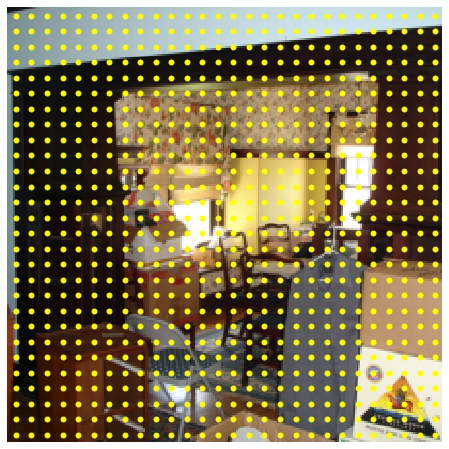

********************************************************************************
All locations of the image FPN level = p4
stride = 16


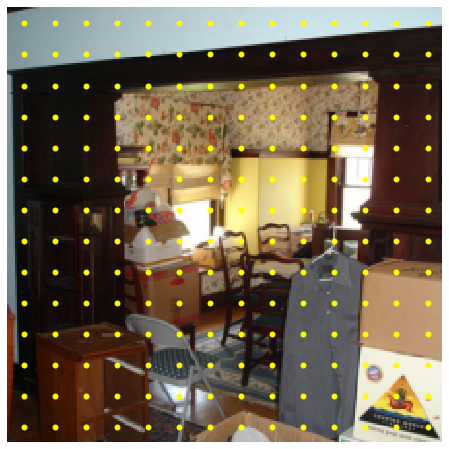

********************************************************************************
All locations of the image FPN level = p5
stride = 32


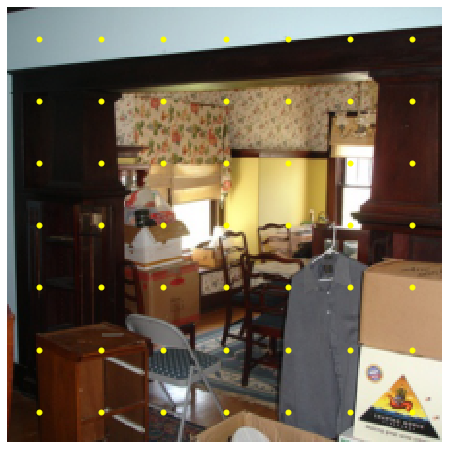

In [ ]:
# Get shapes of each FPN level feature map. We don't call these "dummy" because
# they don't depend on the _values_ of features, but rather only shapes.
fpn_feats_shapes = {
    level_name: feat.shape for level_name, feat in dummy_fpn_feats.items()
}

# Get CPU tensors for this sanity check: (you can pass `device=` argument.
locations_per_fpn_level = get_fpn_location_coords(fpn_feats_shapes, backbone.fpn_strides)

# First five location co-ordinates for each feature maps.

expected_locations = {
    "p3": torch.tensor([[4.0, 4.0], [12.0, 4.0], [20.0, 4.0], [28.0, 4.0], [36.0, 4.0]]),
    "p4": torch.tensor([[8.0, 8.0], [24.0, 8.0], [40.0, 8.0], [56.0, 8.0], [72.0, 8.0]]),
    "p5": torch.tensor([[16.0, 16.0], [48.0, 16.0], [80.0, 16.0], [112.0, 16.0], [144.0, 16.0]]),
}
print("First five locations per FPN level (absolute image co-ordinates):")
for level_name, locations in locations_per_fpn_level.items():
    print(f"{level_name}: {locations[:5, :].tolist()}")
    print("rel error: ", rel_error(expected_locations[level_name], locations[:5, :]))

# Visualize all the locations on first image from training data.
for level_name, locations in locations_per_fpn_level.items():
    # Un-normalize image to bring in [0, 1] RGB range.
    image = inverse_norm(val_dataset[0][1])

    print("*" * 80)
    print(f"All locations of the image FPN level = {level_name}")
    print(f"stride = {backbone.fpn_strides[level_name]}")
    detection_visualizer(image, val_dataset.idx_to_class, points=locations.tolist())

**NOTE:** We will use "feature map location" and "feature center" interchangeably from now on, they mean the same thing — center of the receptive field of a particular feature map location at any FPN level **(green points above)**.

### 7.1 (e) Matching feature map locations with GT boxes

Now we match these locations with GT boxes for supervising our network. FCOS matches some `N` locations at any given FPN level with `M` GT boxes applying two rules:

> Location $N_i$ is matched with box $M_i$ if it lies inside the box. If any location lies inside two boxes, then it is matched with the smaller box. If a location does not lie inside any box, it is assigned "background".

> _Multi-scale matching_ for different FPN levels — for a particular FPN level, FCOS only considers a subset of boxes based on their size. Intuitively, larger boxes are assigned to `p5` and smaller boxes are assigned to `p3`.

As a result of this matching, each location wil receive a bounding box and a class label (that is 5D vector `(x1, y1, x2, y2, C)`) out of `M` GT boxes, or a background `(-1, -1, -1, -1, -1)`.

We have implemented this matching procedure for you, because we thought it is non-trivial for the limited time and difficulty level of this assignment.
However, you are required to understand its input/output format and how to use it, shown in the following cell.
We recommend you to read its implementation in `ps7_helpers.py` with name `fcos_match_locations_to_gt`. While not required for this assignment, you may refer to [Section 3.2 in FCOS paper](https://arxiv.org/abs/1904.01355).

In [ ]:
from ps7_helpers import fcos_match_locations_to_gt

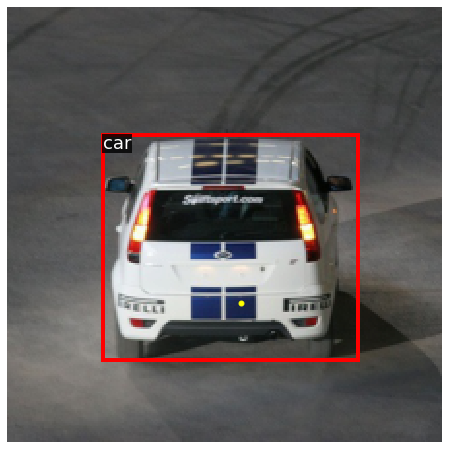

In [ ]:
# Get an image and its GT boxes from train dataset.
#try with different images using index 1,2,3...
_, image, gt_boxes = train_dataset[0]

# Dictionary with keys {"p3", "p4", "p5"} and values as `(N, 5)` tensors
# giving matched GT boxes.
matched_boxes_per_fpn_level = fcos_match_locations_to_gt(
    locations_per_fpn_level, backbone.fpn_strides, gt_boxes
)

# Visualize one selected location (yellow point) and its matched GT box (red).
# Get indices of matched locations (whose class ID is not -1) from P3 level.
FPN_LEVEL = "p4"
# NOTE: Run this cell multiple times with FPN_LEVEL = p4,p5 to see different matched points. 
# For car image, p3/5 will not work because the one and only box was already assigned
# to p4 due to its compatible size to p4 stride. Similarly for some other images

fg_idxs_p3 = (matched_boxes_per_fpn_level[FPN_LEVEL][:, 4] != -1).nonzero()

_idx = random.choice(fg_idxs_p3)

detection_visualizer(
    inverse_norm(image),
    val_dataset.idx_to_class,
    bbox=matched_boxes_per_fpn_level[FPN_LEVEL][_idx],
    points=locations_per_fpn_level[FPN_LEVEL][_idx]
)

In the above illustration, we can see one random location on `p3` level (**yellow dot**), and its matched GT box (**red**).
With these GT targets assigned, the FCOS preiction heads are task to predict this class label (**person**) at the given location, regress the distances between this location to all box edges `(left, top, right, bottom)`, and regress a real-valued centerness at this location. 

From now on, it would help to think about FCOS behavior for a _single_ location, assuming that it has a matched GT box (or background). We shall now discuss and implement the output format of prediction layers and loss functions during training.

### 7.1 (f) GT Targets for box regression
The box regression head is tasked with predicting **FOUR** values which are the distances from feature locations (yellow dots) to box edges (red box) as we discussed above (left, top, right, bottom) or simply as we could call it — LTRB. 

Recall that all locations and GT boxes so far are represented in absolute image co-ordinates — they range from (0, 224) for our input image, and can be even larger for abritrarily large input images.

We cannot use this absolute co-ordinate format with our network because regressing to such large real-valued numbers will cause the gradients to explode. Hence, FCOS normalizes LTRB targets by the stride of FPN levels. Hence in the above example, consider FPN level P3 (stride = 8), the location to be (xc, yc) (yellow point) and matched GT box have co-ordinates `(x1, y1, x2, y2)`. Then the LTRB regression targets used to supervise the network are:



```
l = (xc - x1) / stride              t = (yc - y1) / stride
r = (x2 - xc) / stride              b = (y2 - yc) / stride
```


These are commonly referred as "deltas" of box regression. Since the model is supervised to predict these during training time, one must apply an inverse transformation to these during inference to convert network outputs to predicted boxes in absolute image co-ordinates.

Next, you will implement this transformation logic and its inverse in two separate functions:

`fcos_get_deltas_from_locations` : Accepts locations (centers) and GT boxes, and returns deltas. Required for training supervision.

`fcos_apply_deltas_to_locations`: Accepts predicted deltas and locations, and returns predicted boxes. Required during inference.
Run the following cell to check your implementation.

In [ ]:
def fcos_get_deltas_from_locations(
    locations: torch.Tensor, gt_boxes: torch.Tensor, stride: int
) -> torch.Tensor:
    """
    Compute distances from feature locations to GT box edges. These distances
    are called "deltas" - `(left, top, right, bottom)` or simply `LTRB`. The
    feature locations and GT boxes are given in absolute image co-ordinates.

    These deltas are used as targets for training FCOS to perform box regression
    and centerness regression. They must be "normalized" by the stride of FPN
    feature map (from which feature locations were computed, see the function
    `get_fpn_location_coords`). If GT boxes are "background", then deltas must
    be `(-1, -1, -1, -1)`.

    NOTE: This transformation function should not require GT class label. Your
    implementation must work for GT boxes being `(N, 4)` or `(N, 5)` tensors -
    without or with class labels respectively. You may assume that all the
    background boxes will be `(-1, -1, -1, -1)` or `(-1, -1, -1, -1, -1)`.

    Args:
        locations: Tensor of shape `(N, 2)` giving `(xc, yc)` feature locations.
        gt_boxes: Tensor of shape `(N, 4 or 5)` giving GT boxes.
        stride: Stride of the FPN feature map.

    Returns:
        torch.Tensor
            Tensor of shape `(N, 4)` giving deltas from feature locations, that
            are normalized by feature stride.
    """
    ##########################################################################
    # TODO: Implement the logic to get deltas from feature locations.        #
    ##########################################################################
    # Set this to Tensor of shape (N, 4) giving deltas (left, top, right, bottom)
    # from the locations to GT box edges, normalized by FPN stride.
    l = (locations[:,0] - gt_boxes[:,0]) / stride
    l = l.view([-1,1])
    t = (locations[:,1] - gt_boxes[:,1]) / stride
    t = t.view([-1,1])
    r = (gt_boxes[:,2] - locations[:,0]) / stride
    r = r.view([-1,1])
    b = (gt_boxes[:,3] - locations[:,1]) / stride
    b = b.view([-1,1])

    deltas = torch.cat((l,t,r,b), axis=1)
    deltas = torch.where(gt_boxes[:,0:4] == -1, -1, deltas)
    
    ##########################################################################
    #                             END OF YOUR CODE                           #
    ##########################################################################

    return deltas

In [ ]:
def fcos_apply_deltas_to_locations(
    deltas: torch.Tensor, locations: torch.Tensor, stride: int
) -> torch.Tensor:
    """
    Implement the inverse of `fcos_get_deltas_from_locations` here:

    Given edge deltas (left, top, right, bottom) and feature locations of FPN, get
    the resulting bounding box co-ordinates by applying deltas on locations. This
    method is used for inference in FCOS: deltas are outputs from model, and
    applying them to anchors will give us final box predictions.

    Recall in above method, we were required to normalize the deltas by feature
    stride. Similarly, we have to un-normalize the input deltas with feature
    stride before applying them to locations, because the given input locations are
    already absolute co-ordinates in image dimensions.

    Args:
        deltas: Tensor of shape `(N, 4)` giving edge deltas to apply to locations.
        locations: Locations to apply deltas on. shape: `(N, 2)`
        stride: Stride of the FPN feature map.

    Returns:
        torch.Tensor
            Same shape as deltas and locations, giving co-ordinates of the
            resulting boxes `(x1, y1, x2, y2)`, absolute in image dimensions.
    """
    ##########################################################################
    # TODO: Implement the transformation logic to get boxes.                 #
    #                                                                        #
    # NOTE: The model predicted deltas MAY BE negative, which is not valid   #
    # for our use-case because the feature center must lie INSIDE the final  #
    # box. Make sure to clip them to zero.                                   #
    ##########################################################################
    # Replace "pass" statement with your code

    clipped_delta = torch.where(deltas < 0, 0, deltas)
    x1 = locations[:,0] - stride * clipped_delta[:,0]
    x1 = x1.view([-1,1])
    y1 = locations[:,1] - stride * clipped_delta[:,1]
    y1 = y1.view([-1,1])
    x2 = locations[:,0] + stride * clipped_delta[:,2]
    x2 = x2.view([-1,1])
    y2 = locations[:,1] + stride * clipped_delta[:,3]
    y2 = y2.view([-1,1])

    output_boxes = torch.cat((x1,y1,x2,y2), axis=1)
    output_boxes = torch.where(deltas == -1, -1, output_boxes)
    
    ##########################################################################
    #                             END OF YOUR CODE                           #
    ##########################################################################

    return output_boxes

In [ ]:
# Three hard-coded input boxes and three points lying inside them.
# Add a dummy class ID = 1 indicating foreground
input_boxes = torch.Tensor(
    [[10, 15, 100, 115, 1], [30, 20, 40, 30, 1], [120, 100, 200, 200, 1]]
)
input_locations = torch.Tensor([[30, 40], [32, 29], [125, 150]])

# Here we do a simple sanity check - getting deltas for a particular set of boxes
# and applying them back to centers should give us the same boxes. Setting a random
# stride = 8, it should not affect reconstruction if it is same on both sides.
_deltas = fcos_get_deltas_from_locations(input_locations, input_boxes, stride=8)
output_boxes = fcos_apply_deltas_to_locations(_deltas, input_locations, stride=8)

print("Rel error in reconstructed boxes:", rel_error(input_boxes[:, :4], output_boxes))


# Another check: deltas for GT class label = -1 should be -1.
background_box = torch.Tensor([[-1, -1, -1, -1, -1]])
input_location = torch.Tensor([[100, 200]])

_deltas = fcos_get_deltas_from_locations(input_location, background_box, stride=8)
output_box = fcos_apply_deltas_to_locations(_deltas, input_location, stride=8)

print("Background deltas should be all -1    :", _deltas)

# Output box should be the location itself ([100, 200, 100, 200])
print("Output box with background deltas     :", output_box)

Rel error in reconstructed boxes: 0.0
Background deltas should be all -1    : tensor([[-1., -1., -1., -1.]])
Output box with background deltas     : tensor([[-1., -1., -1., -1.]])


### 7.1 (g) GT targets for centerness regression

Given the GT deltas for a location `(left, top, right, bottom)` as computed above, FCOS defines centerness as:

$$centerness = \sqrt{\frac{\min(left, right) \cdot \min(top, bottom)}{\max(left, right) \cdot \max(top, bottom)}}$$

This value is maximum (1) when `left = right` and `top = bottom`, implying the center of GT box.
At the edge of a box, one of these values will be zero, which gives zero centerness at edges.
Centerness regression head uses these values as targets.

We have implemented this function for you as centerness is not a focus of this problem set. Run the cell below to import the function from `ps7_helpers.py`. If you want, you can open the file and get an understanding of how it works.

In [ ]:
from ps7_helpers import fcos_make_centerness_targets

### 7.1 (h) Loss Functions

At this point, every model prediction is assigned a GT target during training.
We will proceed to compute losses for training the model.

FCOS has three prediction layers, that use the following use functions:

1. **Object classification:** FCOS uses [Sigmoid Focal Loss](https://arxiv.org/abs/1708.02002), an extension of cross-entropy loss that deals with class-imbalance. FCOS faces a class imbalance issue because a majority of locations would be assigned "background". If not handled properly, the model will simply learn to predict "background" for every location. We will use thee torch implementation of this loss directly using `torchvision.ops.sigmoid_focal_loss`. You can read more about it in the [torch documentation](https://pytorch.org/vision/stable/generated/torchvision.ops.sigmoid_focal_loss.html)

2. **Box regression:** The FCOS paper uses [Generalized Intersection-over-Union](https://giou.stanford.edu/) loss to minimize the difference between predicted and GT `LTRB` deltas. You are not required to understand GIoU for this assignment. We will use the Torch implementation of this loss directly using `torchvision.ops.generalized_box_iou_loss`. It is used very similarly to the other Torch losses we have used so far. You can read more about it in the [Torch documentation](https://pytorch.org/vision/stable/generated/torchvision.ops.generalized_box_iou_loss.html)

3. **Centerness regression:** Centerness predictions and GT targets are real-valued numbers in `[0, 1]`, so FCOS uses binary cross-entropy (BCE) loss to optimize it. One may use an L1 loss, but BCE empirically works slightly better.

**Total loss:** We get three loss components _per location_. Out of these, (2) and (3) are set to zero for _background locations_ because their GT boxes (and hence centerness) are not defined. Total loss is the sum of all losses per location, averaged by the number of _foreground locations_ (that matched with any GT box). The number of foreground locations are highly variable per image, depending on density of objects in it. Hence for training stability, the loss is instead average by an _exponential moving average of foreground locations_ (think like the running mean/var of BN, in past assignment).

You have implemented some basic forms of these losses in past assignment.
So now you are allowed to directly use builtin functions from PyTorch and Torchvision.
We highly encourage you to check out their implementation and understand them closely.

The following two cells demonstrate their use with dummy inputs and targets.
Execute them and read them carefully so you understand how to call these functions — immediately after, you will use them with actual predictions of FCOS, and assigned GT targets (that you implemented so far).

In [ ]:
# Sanity check: dummy model predictions for TWO locations, and
# NUM_CLASSES = 5 (typically there are thousands of locations
# across all FPN levels).
# shape: (batch_size, num_locations, num_classes)
dummy_pred_cls_logits = torch.randn(1, 2, 5)

# Corresponding one-hot vectors of GT class labels (2, -1), one
# foreground and one background.
# shape: (batch_size, num_locations, num_classes)
dummy_gt_classes = torch.Tensor([[[0, 0, 1, 0, 0], [0, 0, 0, 0, 0]]])

# This loss expects logits, not probabilities (DO NOT apply sigmoid!)
cls_loss = sigmoid_focal_loss(
    inputs=dummy_pred_cls_logits, targets=dummy_gt_classes
)
#this value is completely random
print("Classification loss (dummy inputs/targets):")
print(cls_loss)

#this value is completely random
print(f"Total classification loss (un-normalized): {cls_loss.sum()}")

#the purpose of this sanity check is to give you an idea of how to use the different losses

Classification loss (dummy inputs/targets):
tensor([[[0.0461, 0.0658, 0.0145, 0.0745, 0.1988],
         [0.0115, 0.5657, 0.0022, 0.7302, 0.1034]]])
Total classification loss (un-normalized): 1.8126591444015503


In [ ]:
# Sanity check: dummy model predictions for TWO locations, and
# NUM_CLASSES = 2 (typically there are thousands of locations
# across all FPN levels).
# Think of these as first two locations locations of "p5" level.
dummy_locations = torch.Tensor([[32, 32], [64, 32]])
dummy_gt_boxes = torch.Tensor(
    [
        [1, 2, 40, 50, 2],
        [-1, -1, -1, -1, -1]  # Same GT classes as above cell.
    ]
)
# Centerness is just a dummy value:
dummy_gt_centerness = torch.Tensor([0.6, -1])

# shape: (batch_size, num_locations, 4 or 1)
dummy_pred_boxreg_deltas = torch.randn(1, 2, 4)
dummy_pred_ctr_logits = torch.randn(1, 2, 1)

# Collapse batch dimension.
dummy_pred_boxreg_deltas = dummy_pred_boxreg_deltas.view(-1, 4)
dummy_pred_ctr_logits = dummy_pred_ctr_logits.view(-1)

dummy_pred_boxes=fcos_apply_deltas_to_locations(dummy_pred_boxreg_deltas,dummy_locations,stride=32)

# First calculate box reg loss, comparing predicted boxes and GT boxes.
dummy_gt_deltas = fcos_get_deltas_from_locations(
    dummy_locations, dummy_gt_boxes, stride=32
)

loss_box=torchvision.ops.generalized_box_iou_loss(dummy_pred_boxes,dummy_gt_boxes[:,:4],reduction="none")

# No loss for background:
dummy_gt_boxes_cloned=dummy_gt_boxes[:,4].clone().reshape(-1)
bg_indices=dummy_gt_boxes_cloned==-1
loss_box[bg_indices] = 0.0
print("Box regression loss (GIoU):", loss_box)

#loss_box=torchvision.ops.generalized_box_iou_loss(dummy_pred_boxes,dummy_gt_boxes,reduction="none")
# Now calculate centerness loss.
centerness_loss = F.binary_cross_entropy_with_logits(
    dummy_pred_ctr_logits, dummy_gt_centerness, reduction="none"
)

# No loss for background:
centerness_loss[dummy_gt_centerness < 0] *= 0.0
print("Centerness loss (BCE):", centerness_loss)

# In both the expected losses, the first value will be different everytime due to random dummy
# predictions. But the second value should always be zero - corresponding to background.

Box regression loss (GIoU): tensor([1.2842, 0.0000])
Centerness loss (BCE): tensor([0.6773, -0.0000])


### 7.1 (i) Object detection module

We will now combine everything into the `FCOS` class.
Implement the `__init__` and `forward` functions of this module — you have already done most of the heavy lifting, you simply need to call the functions in a correct way!
Use the previous two cells as a reference to implement loss calculation in `forward()`.

You can come back and implement the `inference` function later after you have successfully trained the model.

In [ ]:
class FCOS(nn.Module):
    """
    FCOS: Fully-Convolutional One-Stage Detector

    This class puts together everything you implemented so far. It contains a
    backbone with FPN, and prediction layers (head). It computes loss during
    training and predicts boxes during inference.
    """

    def __init__(
        self, num_classes: int, fpn_channels: int, stem_channels: List[int]
    ):
        super().__init__()
        self.num_classes = num_classes

        ######################################################################
        # TODO: Initialize backbone and prediction network using arguments.  #
        ######################################################################

        self.backbone = DetectorBackboneWithFPN(fpn_channels)
        self.pred_net = FCOSPredictionNetwork(num_classes, fpn_channels, stem_channels)

        ######################################################################
        #                           END OF YOUR CODE                         #
        ######################################################################

        # Averaging factor for training loss; EMA of foreground locations.
        # STUDENTS: See its use in `forward` when you implement losses.
        self._normalizer = 150  # per image

    def forward(
        self,
        images: torch.Tensor,
        gt_boxes: Optional[torch.Tensor] = None,
        test_score_thresh: Optional[float] = None,
        test_nms_thresh: Optional[float] = None,
    ):
        """
        Args:
            images: Batch of images, tensors of shape `(B, C, H, W)`.
            gt_boxes: Batch of training boxes, tensors of shape `(B, N, 5)`.
                `gt_boxes[i, j] = (x1, y1, x2, y2, C)` gives information about
                the `j`th object in `images[i]`. The position of the top-left
                corner of the box is `(x1, y1)` and the position of bottom-right
                corner of the box is `(x2, x2)`. These coordinates are
                real-valued in `[H, W]`. `C` is an integer giving the category
                label for this bounding box. Not provided during inference.
            test_score_thresh: During inference, discard predictions with a
                confidence score less than this value. Ignored during training.
            test_nms_thresh: IoU threshold for NMS during inference. Ignored
                during training.

        Returns:
            Losses during training and predictions during inference.
        """

        ######################################################################
        # TODO: Process the image through backbone, FPN, and prediction head #
        # to obtain model predictions at every FPN location.                 #
        # Get dictionaries of keys {"p3", "p4", "p5"} giving predicted class #
        # logits, deltas, and centerness.                                    #
        ######################################################################

        backbone_out = self.backbone(images)
        pred_cls_logits, pred_boxreg_deltas, pred_ctr_logits = self.pred_net(backbone_out)

        ######################################################################
        # TODO: Get absolute co-ordinates `(xc, yc)` for every location in
        # FPN levels.
        #
        # HINT: You have already implemented everything, just have to
        # call the functions properly.
        ######################################################################

        fpn_feats_shapes = {
            "p3" : backbone_out["p3"].shape,
            "p4" : backbone_out["p4"].shape,
            "p5" : backbone_out["p5"].shape
        }
        locations_per_fpn_level = get_fpn_location_coords(fpn_feats_shapes, 
                                                          self.backbone.fpn_strides,
                                                          device=DEVICE)

        ######################################################################
        #                           END OF YOUR CODE                         #
        ######################################################################

        if not self.training:
            # During inference, just go to this method and skip rest of the
            # forward pass.
            # fmt: off
            return self.inference(
                images, locations_per_fpn_level,
                pred_cls_logits, pred_boxreg_deltas, pred_ctr_logits,
                test_score_thresh=test_score_thresh,
                test_nms_thresh=test_nms_thresh,
            )
            # fmt: on

        ######################################################################
        # TODO: Assign ground-truth boxes to feature locations. We have this
        # implemented in a `fcos_match_locations_to_gt`. 
        # Find the predicted boxes (to be used to calculate the box loss) for 
        # each feature location using the predicted boxreg deltas
        # Both the operations are NOT
        # batched so call it separately per GT boxes / predicted boxes in batch.
        ######################################################################
        
        # List of dictionaries with keys {"p3", "p4", "p5"} giving matched
        # boxes for locations per FPN level, per image. Fill this list:
        matched_gt_boxes = []
        for i in range(images.shape[0]):
            matched_gt_boxes.append(fcos_match_locations_to_gt(
                                      locations_per_fpn_level, 
                                      self.backbone.fpn_strides, 
                                      gt_boxes[i,:,:]
                                      )
                                    )

        # Calculate GT deltas for these matched boxes. Similar structure
        # as `matched_gt_boxes` above. Fill this list:
        matched_gt_deltas = []
        for i in range(images.shape[0]):
            matched_delta={}
            for level_name,feat_location in locations_per_fpn_level.items():
                matched_delta[level_name] = fcos_get_deltas_from_locations(
                    feat_location, 
                    matched_gt_boxes[i][level_name], 
                    self.backbone.fpn_strides[level_name]
                    )
            matched_gt_deltas.append(matched_delta)
  
        # Calculate predicted boxes from the predicted deltas. Similar structure
        # as `matched_gt_boxes` above. Fill this list:
        pred_boxes=[]
        for i in range(images.shape[0]):
            pred_box={}
            for level_name in locations_per_fpn_level.keys():
                pred_box[level_name] = fcos_apply_deltas_to_locations(
                    pred_boxreg_deltas[level_name][i], 
                    locations_per_fpn_level[level_name], 
                    self.backbone.fpn_strides[level_name]
                    )
            pred_boxes.append(pred_box)

  
        ######################################################################
        #                           END OF YOUR CODE                         #
        ######################################################################

        # Collate lists of dictionaries, to dictionaries of batched tensors.
        # These are dictionaries with keys {"p3", "p4", "p5"} and values as
        # tensors of shape (batch_size, locations_per_fpn_level, 5 or 4)
        matched_gt_boxes = default_collate(matched_gt_boxes)
        matched_gt_deltas = default_collate(matched_gt_deltas)
        pred_boxes= default_collate(pred_boxes)

        # Combine predictions and GT from across all FPN levels.
        # shape: (batch_size, num_locations_across_fpn_levels, ...)
        matched_gt_boxes = self._cat_across_fpn_levels(matched_gt_boxes)
        matched_gt_deltas = self._cat_across_fpn_levels(matched_gt_deltas)
        pred_cls_logits = self._cat_across_fpn_levels(pred_cls_logits)
        pred_boxreg_deltas = self._cat_across_fpn_levels(pred_boxreg_deltas)
        pred_ctr_logits = self._cat_across_fpn_levels(pred_ctr_logits)
        pred_boxes = self._cat_across_fpn_levels(pred_boxes)

        # Perform EMA update of normalizer by number of positive locations.
        num_pos_locations = (matched_gt_boxes[:, :, 4] != -1).sum()
        pos_loc_per_image = num_pos_locations.item() / images.shape[0]
        self._normalizer = 0.9 * self._normalizer + 0.1 * pos_loc_per_image

        #######################################################################
        # TODO: Calculate losses per location for classification, box reg and
        # centerness. Remember to set box/centerness losses for "background"
        # positions to zero.
        ######################################################################
        # Feel free to delete this line: (but keep variable names same)
        loss_cls, loss_box, loss_ctr = None, None, None

        gt_classes = matched_gt_boxes[:,:,4].clone()
        bg_mask = gt_classes==-1
        gt_classes[bg_mask] = 0
        gt_classes_one_hot = torch.nn.functional.one_hot(gt_classes.long(),self.num_classes)
        gt_classes_one_hot = gt_classes_one_hot.to(gt_boxes.dtype)
        gt_classes_one_hot[bg_mask] = 0
        loss_cls = sigmoid_focal_loss(inputs=pred_cls_logits, targets=gt_classes_one_hot)

        pred_boxreg_deltas = pred_boxreg_deltas.reshape(-1,4)
        matched_gt_deltas = matched_gt_deltas.reshape(-1,4)
        # Find the background images 
        matched_boxes = matched_gt_boxes[:,:,4].clone().reshape(-1)
        background_mask = matched_boxes==-1        
        #Calculate the box loss
        loss_box = torchvision.ops.generalized_box_iou_loss(
            pred_boxes.reshape(-1,4), 
            matched_gt_boxes[:,:,:4].reshape(-1,4),
            reduction="none"
            )
        # Do not count the loss of background images 
        loss_box[background_mask] = 0
        pred_ctr_logits = pred_ctr_logits.view(-1)
        gt_centerness = fcos_make_centerness_targets(matched_gt_deltas)
        loss_ctr = F.binary_cross_entropy_with_logits(pred_ctr_logits, gt_centerness, reduction="none")
        loss_ctr[gt_centerness<=0] = 0


        ######################################################################
        #                            END OF YOUR CODE                        #
        ######################################################################
        
        # Sum all locations and average by the EMA of foreground locations.
        # In training code, we simply add these three and call `.backward()`
        return {
            "loss_cls": loss_cls.sum() / (self._normalizer * images.shape[0]),
            "loss_box": loss_box.sum() / (self._normalizer * images.shape[0]),
            "loss_ctr": loss_ctr.sum() / (self._normalizer * images.shape[0]),
        }

    @staticmethod
    def _cat_across_fpn_levels(
        dict_with_fpn_levels: Dict[str, torch.Tensor], dim: int = 1
    ):
        """
        Convert a dict of tensors across FPN levels {"p3", "p4", "p5"} to a
        single tensor. Values could be anything - batches of image features,
        GT targets, etc.
        """
        return torch.cat(list(dict_with_fpn_levels.values()), dim=dim)

    

    def inference(
        self,
        images: torch.Tensor,
        locations_per_fpn_level: Dict[str, torch.Tensor],
        pred_cls_logits: Dict[str, torch.Tensor],
        pred_boxreg_deltas: Dict[str, torch.Tensor],
        pred_ctr_logits: Dict[str, torch.Tensor],
        test_score_thresh: float = 0.3,
        test_nms_thresh: float = 0.5,
    ):
        """
        Run inference on a single input image (batch size = 1). Other input
        arguments are same as those computed in `forward` method. This method
        should not be called from anywhere except from inside `forward`.

        Returns:
            Three tensors:
                - pred_boxes: Tensor of shape `(N, 4)` giving *absolute* XYXY
                  co-ordinates of predicted boxes.

                - pred_classes: Tensor of shape `(N, )` giving predicted class
                  labels for these boxes (one of `num_classes` labels). Make
                  sure there are no background predictions (-1).

                - pred_scores: Tensor of shape `(N, )` giving confidence scores
                  for predictions: these values are `sqrt(class_prob * ctrness)`
                  where class_prob and ctrness are obtained by applying sigmoid
                  to corresponding logits.
        """

        # Gather scores and boxes from all FPN levels in this list. Once
        # gathered, we will perform NMS to filter highly overlapping predictions.
        pred_boxes_all_levels = []
        pred_classes_all_levels = []
        pred_scores_all_levels = []

        for level_name in locations_per_fpn_level.keys():

            # Get locations and predictions from a single level.
            # We index predictions by `[0]` to remove batch dimension.
            level_locations = locations_per_fpn_level[level_name]
            level_cls_logits = pred_cls_logits[level_name][0]
            level_deltas = pred_boxreg_deltas[level_name][0]
            level_ctr_logits = pred_ctr_logits[level_name][0]

            ##################################################################
            # TODO: FCOS uses the geometric mean of class probability and
            # centerness as the final confidence score. This helps in getting
            # rid of excessive amount of boxes far away from object centers.
            # Compute this value here (recall sigmoid(logits) = probabilities)
            #
            # Then perform the following steps in order:
            #   1. Get the most confidently predicted class and its score for
            #      every box. Use level_pred_scores: (N, num_classes) => (N, )
            #   2. Only retain prediction that have a confidence score higher
            #      than provided threshold in arguments.
            #   3. Obtain predicted boxes using predicted deltas and locations
            #   4. Clip XYXY box-cordinates that go beyond thr height and
            #      and width of input image.
            ##################################################################
            # Feel free to delete this line: (but keep variable names same)
            level_pred_boxes, level_pred_classes, level_pred_scores = (
                None,
                None,
                None,  # Need tensors of shape: (N, 4) (N, ) (N, )
            )

            # Compute geometric mean of class logits and centerness:
            level_pred_scores = torch.sqrt(
                level_cls_logits.sigmoid_() * level_ctr_logits.sigmoid_()
            )

            # Step 1:
            # Replace "pass" statement with your code
            level_pred_scores, level_pred_classes = torch.max(level_pred_scores, dim=1)

            # Step 2:
            # Replace "pass" statement with your code
            mask_to_retain = level_pred_scores > test_score_thresh
            level_pred_classes = level_pred_classes[mask_to_retain]
            level_pred_scores = level_pred_scores[mask_to_retain]

            # Step 3: Obtain predicted boxes using predicted deltas and locations
            # Replace "pass" statement with your code
            level_pred_boxes = fcos_apply_deltas_to_locations(
                level_deltas, 
                locations_per_fpn_level[level_name],
                self.backbone.fpn_strides[level_name])
            level_pred_boxes = level_pred_boxes[mask_to_retain,:]

            # Step 4: Clip 
            image_height = images.size[2]
            image_width = images.size[3]

            level_pred_boxes[:,2] = torch.clamp_max(level_pred_boxes[:,2],image_width)
            level_pred_boxes[:,3] = torch.clamp_max(level_pred_boxes[:,3],image_height)

            ##################################################################
            #                          END OF YOUR CODE                      #
            ##################################################################

            pred_boxes_all_levels.append(level_pred_boxes)
            pred_classes_all_levels.append(level_pred_classes)
            pred_scores_all_levels.append(level_pred_scores)

        ######################################################################
        # Combine predictions from all levels and perform NMS.
        pred_boxes_all_levels = torch.cat(pred_boxes_all_levels)
        pred_classes_all_levels = torch.cat(pred_classes_all_levels)
        pred_scores_all_levels = torch.cat(pred_scores_all_levels)

        # STUDENTS: This function depends on your implementation of NMS.
        keep = class_spec_nms(
            pred_boxes_all_levels,
            pred_scores_all_levels,
            pred_classes_all_levels,
            iou_threshold=test_nms_thresh,
        )
        pred_boxes_all_levels = pred_boxes_all_levels[keep]
        pred_classes_all_levels = pred_classes_all_levels[keep]
        pred_scores_all_levels = pred_scores_all_levels[keep]
        return (
            pred_boxes_all_levels,
            pred_classes_all_levels,
            pred_scores_all_levels,
        )

## 7.1 (j) Overfit small data

We have implemented the `train_detector` function which runs the training loop for this FCOS detector. You can read its implementation in `ps7_helpers.py`. 

To make sure that everything is working as expected, we can try to overfit the detector to a small subset of data.

**NOTE:** The training loss may start low and end up higher at the end of 500 iterations, that is fine. The main training loop later will work better.

For dummy input images with shape: (2, 3, 224, 224)
Shape of c3 features: torch.Size([2, 64, 28, 28])
Shape of c4 features: torch.Size([2, 160, 14, 14])
Shape of c5 features: torch.Size([2, 400, 7, 7])
[Iter 0][loss: 1.318][loss_cls: 0.526][loss_box: 0.466][loss_ctr: 0.326]
[Iter 20][loss: 2.378][loss_cls: 0.878][loss_box: 0.891][loss_ctr: 0.608]
[Iter 40][loss: 2.740][loss_cls: 0.837][loss_box: 1.135][loss_ctr: 0.767]
[Iter 60][loss: 2.453][loss_cls: 0.734][loss_box: 1.015][loss_ctr: 0.704]
[Iter 80][loss: 2.000][loss_cls: 0.632][loss_box: 0.730][loss_ctr: 0.638]
[Iter 100][loss: 2.187][loss_cls: 0.717][loss_box: 0.784][loss_ctr: 0.687]
[Iter 120][loss: 1.492][loss_cls: 0.516][loss_box: 0.505][loss_ctr: 0.471]
[Iter 140][loss: 1.825][loss_cls: 0.587][loss_box: 0.634][loss_ctr: 0.604]
[Iter 160][loss: 1.782][loss_cls: 0.546][loss_box: 0.623][loss_ctr: 0.614]
[Iter 180][loss: 1.927][loss_cls: 0.563][loss_box: 0.690][loss_ctr: 0.675]
[Iter 200][loss: 1.934][loss_cls: 0.603][loss_box: 0.6

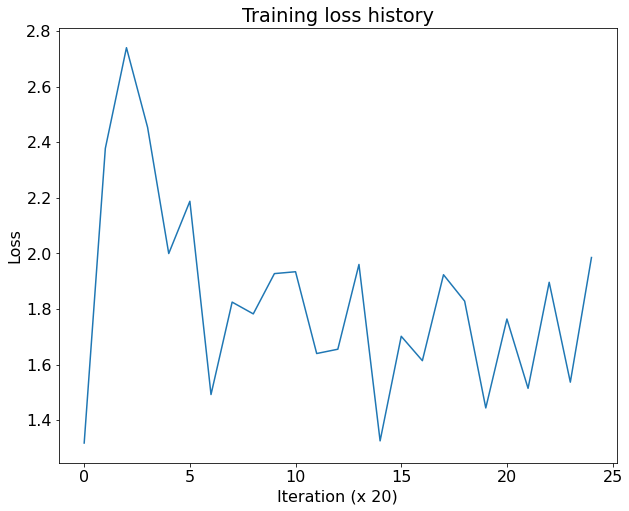

In [ ]:
reset_seed()

detector = FCOS(
    num_classes=NUM_CLASSES,
    fpn_channels=64,
    stem_channels=[64,64],
)
detector = detector.to(DEVICE)

train_detector(
    detector,
    train_loader,
    learning_rate=5e-3,
    max_iters=500,
    log_period=20,
    device=DEVICE,
)

## 7.1 (j) Train a net

Now that we are confident that the training code is working properly, let's train the network on more data and for longer. We will train for 9000 iterations; this should take about 35-40 minutes on a Tesla T4 GPU. For initial debugging, you may want to train for lesser durations (say 1000 iterations). The loss should start at around 1.3, increase for some time and settle at around 0.5-0.8.

Note that real object detection systems typically train for 12-24 hours, distribute training over multiple GPUs, and use much faster GPUs. As such our result will be far from the state of the art, but it should give some reasonable results!

**NOTE:** Pay close attention to the training for initial 1000 iterations, ometimes you might see nan values in the training loss. We have not been able to pinpoint a single cause for this. The best solution we have found for this is to just interrupt the cell execution and run it again. Take note that this may also happen due to coding errors in your case. If the overfit training also shows nan then the problem is most likely in your code.

In [ ]:
#check which GPU you have
!nvidia-smi

Mon Nov  7 04:37:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    34W /  70W |   2604MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

For dummy input images with shape: (2, 3, 224, 224)
Shape of c3 features: torch.Size([2, 64, 28, 28])
Shape of c4 features: torch.Size([2, 160, 14, 14])
Shape of c5 features: torch.Size([2, 400, 7, 7])
[Iter 0][loss: 1.312][loss_cls: 0.524][loss_box: 0.466][loss_ctr: 0.323]
[Iter 100][loss: 2.399][loss_cls: 0.707][loss_box: 1.017][loss_ctr: 0.675]
[Iter 200][loss: 2.380][loss_cls: 0.641][loss_box: 1.060][loss_ctr: 0.680]
[Iter 300][loss: 2.209][loss_cls: 0.518][loss_box: 1.034][loss_ctr: 0.657]
[Iter 400][loss: 2.280][loss_cls: 0.490][loss_box: 1.103][loss_ctr: 0.687]
[Iter 500][loss: 1.899][loss_cls: 0.381][loss_box: 0.941][loss_ctr: 0.576]
[Iter 600][loss: 1.844][loss_cls: 0.369][loss_box: 0.917][loss_ctr: 0.557]
[Iter 700][loss: 1.948][loss_cls: 0.329][loss_box: 0.999][loss_ctr: 0.620]
[Iter 800][loss: 1.817][loss_cls: 0.312][loss_box: 0.937][loss_ctr: 0.569]
[Iter 900][loss: 1.740][loss_cls: 0.300][loss_box: 0.827][loss_ctr: 0.613]
[Iter 1000][loss: 1.800][loss_cls: 0.324][loss_box

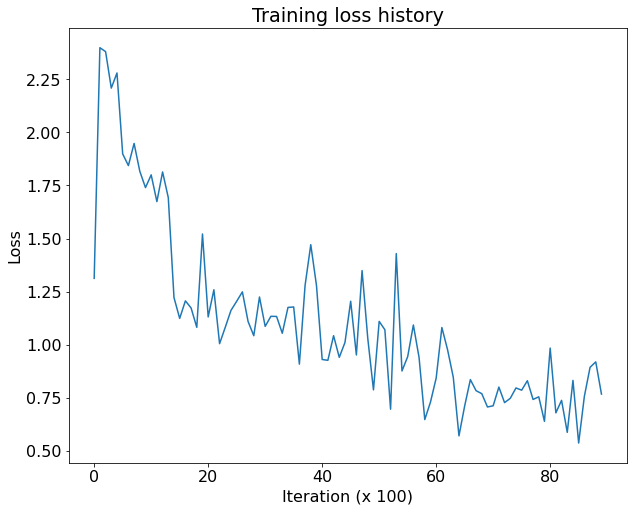

In [ ]:
reset_seed()

# Slightly larger detector than in above cell.
detector = FCOS(
    num_classes=NUM_CLASSES,
    fpn_channels=128,
    stem_channels=[128,128],
)
detector = detector.to(DEVICE)

train_detector(
    detector,
    train_loader,
    learning_rate=5e-3,
    max_iters=9000,
    log_period=100,
    device=DEVICE,
)

Save your trained detector weights

In [ ]:
torch.save(detector.state_dict(), "fcos_detector.pt")

## 7.1 (k) Inference

Now, we will use the trained model to perform inference on the val dataset. We have implemented a helper function for you that makes use of the `inference` function you implemented in `FCOS`. Just run the cell below to get the results.

Visualize the output from the trained model on a few eval images by running the code below, the bounding boxes should be somewhat accurate. They would get even better by using a bigger model and training it for longer.

For dummy input images with shape: (2, 3, 224, 224)
Shape of c3 features: torch.Size([2, 64, 28, 28])
Shape of c4 features: torch.Size([2, 160, 14, 14])
Shape of c5 features: torch.Size([2, 400, 7, 7])


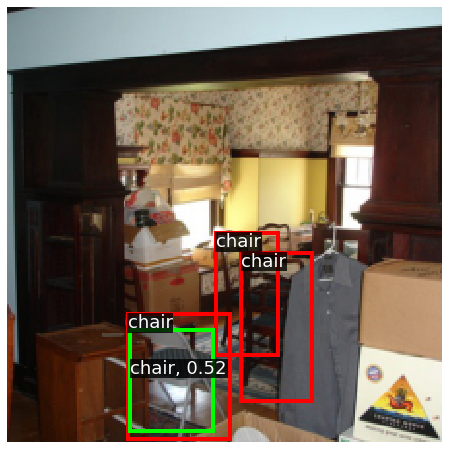

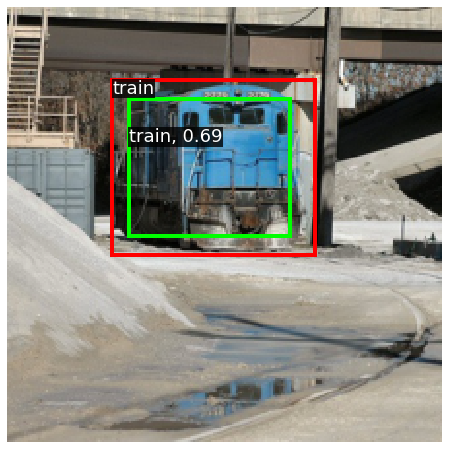

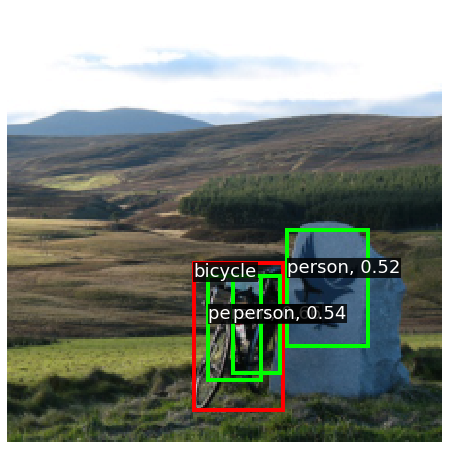

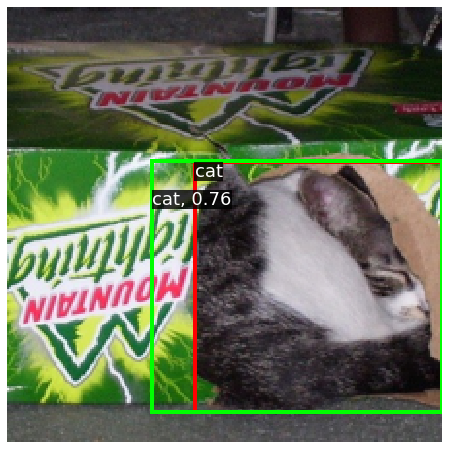

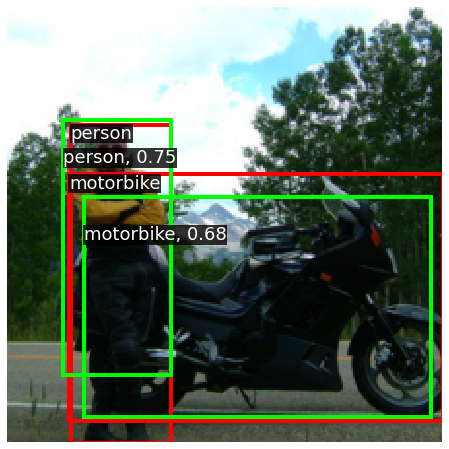

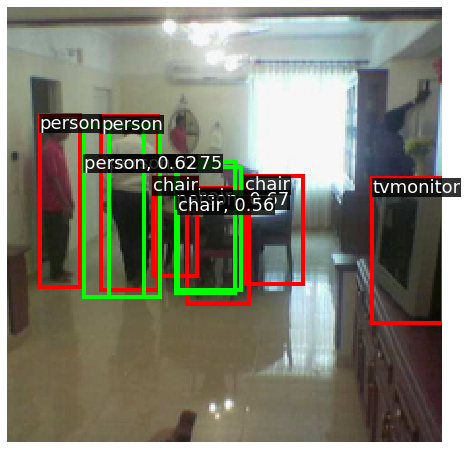

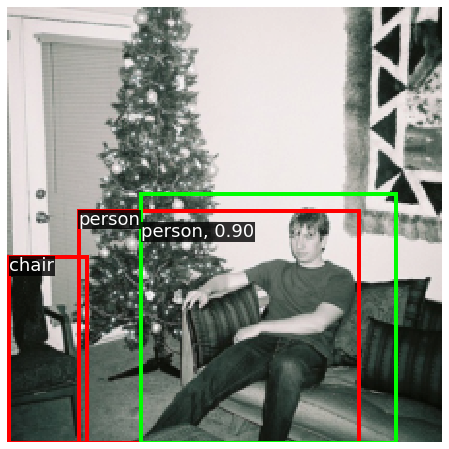

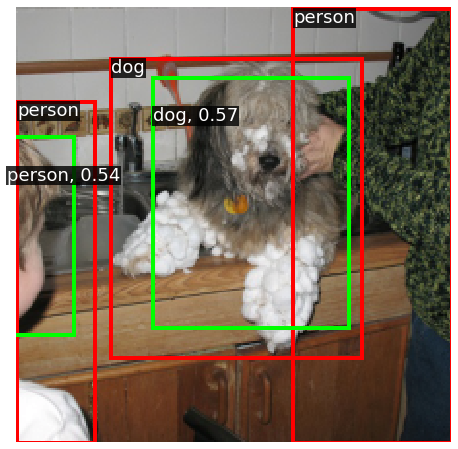

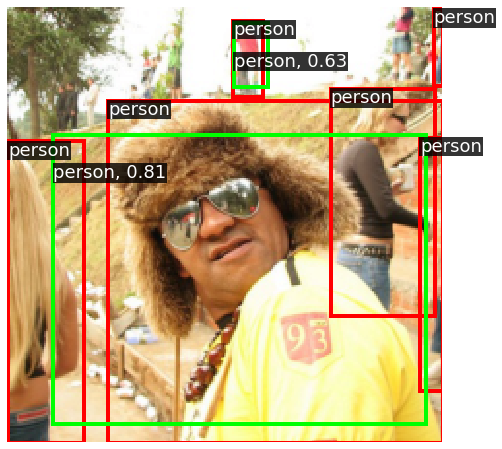

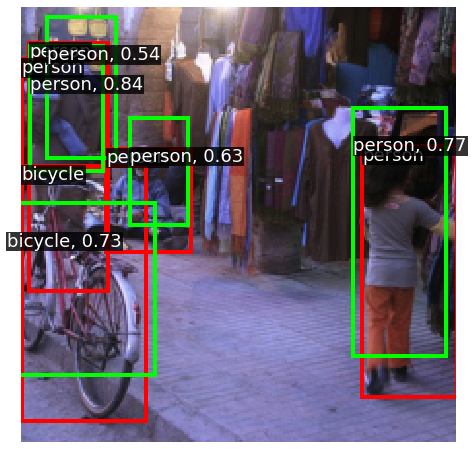

Total inference time: 2.0s


In [ ]:
from ps7_helpers import inference_with_detector, class_spec_nms

weights_path = "fcos_detector.pt"

# Re-initialize so this cell is independent from prior cells.
detector = FCOS(
    num_classes=NUM_CLASSES, fpn_channels=128, stem_channels=[128, 128]
)
detector.to(device=DEVICE)
detector.load_state_dict(torch.load(weights_path, map_location="cpu"))

# Prepare a small val daataset for inference:
small_dataset = torch.utils.data.Subset(
    val_dataset,
    torch.linspace(0, len(val_dataset) - 1, steps=10).long()
)
small_val_loader = torch.utils.data.DataLoader(
    small_dataset, batch_size=1, pin_memory=True, num_workers=NUM_WORKERS
)

image = None
inference_with_detector(
    detector,
    small_val_loader,
    val_dataset.idx_to_class,
    score_thresh=0.5,
    nms_thresh=0.5,
    device=DEVICE,
    dtype=torch.float32,
)

## 7.1 (l) Evaluation
**Compute mean Average Precision (mAP)**. 
For an introduction on mAP see *lecture 11* slides.
Run the following to evaluate your detector on the PASCAL VOC validation set. Evaluation should take a few minutes, and with default hyperparameters declared above, you should see at least 40% mAP.

The state of the art on this dataset is >80% mAP! To achieve these results we would need to use a much bigger network, and train with more data and for much longer, but that is beyond the scope of this assigment. **Optional:** For better mAP, you may use more conv layers in head stem, train for 25K+ iterations, and use ResNet-50/RegNet-4GF models in backbone.
But make sure you revert the code back for grading purposes.

In [ ]:
# for mAP evaluation
!rm -rf mAP
!git clone https://github.com/Cartucho/mAP.git
!rm -rf mAP/input/*

Cloning into 'mAP'...
remote: Enumerating objects: 908, done.
remote: Total 908 (delta 0), reused 0 (delta 0), pack-reused 908
Receiving objects: 100% (908/908), 14.71 MiB | 21.34 MiB/s, done.
Resolving deltas: 100% (321/321), done.


In [ ]:
inference_with_detector(
    detector,
    val_loader,
    val_dataset.idx_to_class,
    score_thresh=0.4,
    nms_thresh=0.6,
    device=DEVICE,
    dtype=torch.float32,
    output_dir="mAP/input",
)

Total inference time: 64.5s


In [ ]:
!cd mAP && python main.py

62.75% = aeroplane AP 
47.67% = bicycle AP 
40.54% = bird AP 
30.06% = boat AP 
6.60% = bottle AP 
51.99% = bus AP 
50.76% = car AP 
75.64% = cat AP 
14.15% = chair AP 
44.53% = cow AP 
44.79% = diningtable AP 
54.25% = dog AP 
64.25% = horse AP 
46.14% = motorbike AP 
42.62% = person AP 
9.19% = pottedplant AP 
28.33% = sheep AP 
38.27% = sofa AP 
76.84% = train AP 
33.98% = tvmonitor AP 
mAP = 43.17%
Figure(640x480)


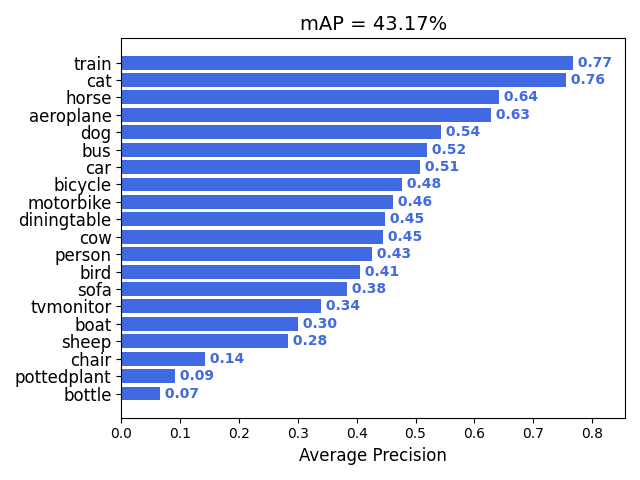

In [ ]:
from IPython.display import Image
Image(filename="./mAP/output/mAP.png")

# Convert Notebook to PDF

[Alternative if the cell below doesn't work.](https://docs.google.com/document/d/1QTutnoApRow8cOxNrKK6ISEkA72QGfwLFXbIcpvarAI/edit?usp=sharing)

In [1]:
import os
from google.colab import drive
from google.colab import files

drive_mount_point = '/content/drive/'
drive.mount(drive_mount_point)

Mounted at /content/drive/


### INSTRUCTIONS: 


*   Please delete the text cells titled "```***Please delete this cell before pdf conversion***```" before running the next cell. 
*   Ensure that you have changed runtime to CPU before conversion



Not following the above will cause an error in pdf conversion.

In [2]:
# generate pdf
# Please provide the full path of the notebook file below
# Important: make sure that your file name does not contain spaces!

# Ex: notebookpath = '/content/drive/My Drive/Colab Notebooks/EECS_442_PS4_FA_2022_Starter_Code.ipynb'
notebookpath = "/content/drive/My Drive/Colab Notebooks/PS7_beprado_PRINT.ipynb"

file_name = notebookpath.split('/')[-1]
get_ipython().system("apt update && apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended")
get_ipython().system("jupyter nbconvert --to PDF {}".format(notebookpath.replace(' ', '\\ ')))
files.download(notebookpath.split('.')[0]+'.pdf')

Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Hit:5 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:6 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:13 http://archive.ubuntu.com/ubuntu b

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>